In [2]:
import torch
import numpy as np
from tqdm import tqdm
from scipy.stats.distributions import chi2
from scipy.stats import pearsonr
import pickle

import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns
import random
import matplotlib.animation as animation
import sys, os

path = os.path.dirname(os.getcwd())
sys.path.append(path)

from utils.plots import *
from utils.funcs import *
from utils.visualize_network import *
from utils.visualize_hidden_network import *

from boltzmann_machines.RTRBM import RTRBM
from boltzmann_machines.RBM import RBM

from data.load_data import *
from data.mock_data import *
from data.reshape_data import *

# spikes, behavior, coordinates, df, stimulus = loaddata()

"""
to dump:

path = os.path.dirname(os.getcwd())
pickle.dump(rtrbm, open(path + '\\results\\RTRBMs\\RTRBMs1', 'wb'))

to load:

check1 = pickle.load(open(path + '\\results\\RTRBMs\\RTRBMs1', 'rb'))
"""

"\nto dump:\n\npath = os.path.dirname(os.getcwd())\npickle.dump(rtrbm, open(path + '\\results\\RTRBMs\\RTRBMs1', 'wb'))\n\nto load:\n\ncheck1 = pickle.load(open(path + '\\results\\RTRBMs\\RTRBMs1', 'rb'))\n"

We have 500+ rtrbms trained on 'reproducing an RTRBM' data, where we randomly initialize W and U and try
to reproduce the weights. Three (nr) RTRBMs are trained on different number of visibles (N_V), hiddens (N_H)
batchsizes (batchsize). All the RTRBMs are saved with the convention for the original RTRBM:
rtrbm_or_N_H_N_V_batchsize_nr and trained RTRBM: rtrbm_N_H_N_V_batchsize_nr.

We need to manually determine when each RTRBM has converged, iff convergence > 3000 than we do not take
the corresponding RTRBM into account.

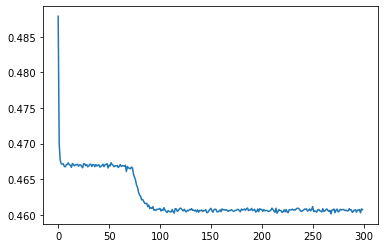

In [8]:
name_rtrbm = 'rtrbm_' +str(2) + '_' + str(200) + '_' + str(750)+ '_' + str(2)
name_original_rtrbm = 'rtrbm_or_' +str(2) + '_' + str(200) + '_' + str(750)+ '_' + str(2)

rtrbm = torch.load(r'C:\Users\sebas\OneDrive\Intern\rtrbm_master\results\invertigating batchsize/' + name_rtrbm, map_location='cpu')
rtrbm_original = torch.load(r'C:\Users\sebas\OneDrive\Intern\rtrbm_master\results\invertigating batchsize/' + name_original_rtrbm, map_location='cpu')

plt.plot(rtrbm.errors[:300])

<AxesSubplot:>

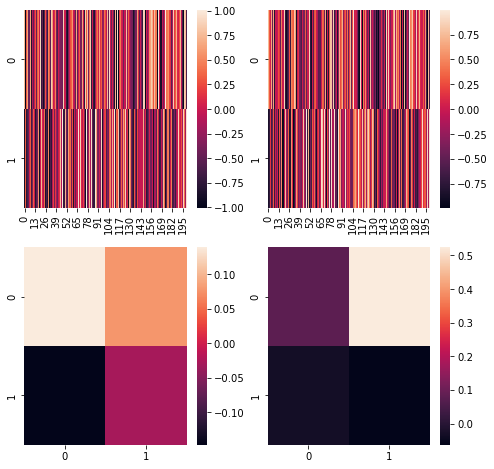

In [9]:
fig, ax = plt.subplots(2,2, figsize=(8,8))
sns.heatmap(rtrbm.VH, ax=ax[0, 0])
sns.heatmap(rtrbm_original.W, ax=ax[0, 1])
sns.heatmap(rtrbm.HH, ax=ax[1, 0])
sns.heatmap(rtrbm_original.W_acc, ax=ax[1, 1])

In [13]:
# Import data

# Note that all the RTRBM combined are larger than 80 GB of space -> Therefore only look at subsets

map_location = 'cuda'
N_H = [1, 3, 6, 9, 12, 18, 24, 30, 2, 6, 12, 18, 24, 36, 48, 60, 4, 12, 24, 36, 48, 72, 96, 120, 8, 24, 48, 72, 96, 144, 192]
N_V = [200, 600, 1200, 1800, 2400, 3600, 4800, 5400]
batchsize = [10, 50, 100, 250, 500, 750, 1000]
nr = [0, 1, 2]
T = 50

#N_H = [1, 3, 6, 9, 12, 18, 24, 30]
#N_H = [2, 6, 12, 18, 24, 36, 48, 60]
#N_H = [4, 12, 24, 36, 48, 72, 96, 120]
#N_H = [8, 24, 48, 72, 96, 144, 192] # misses N_V=5400

# name_rtrbm = 'rtrbm_' +str(N_H[i]) + '_' + str(N_V[i]) + '_' + str(batchsize[b])+ '_' + str(nr[n])
# name_original_rtrbm = 'rtrbm_or_' + str(N_H[i]) + '_' + str(N_V[i]) + '_' + str(batchsize[i])+ '_' + str(nr)
# rtrbm = torch.load(r'C:\Users\sebas\OneDrive\Intern\rtrbm_master\results\invertigating batchsize' + name_rtrbm, map_location=map_location)
# rtrbm_original = torch.load(r'C:\Users\sebas\OneDrive\Intern\rtrbm_master\results\invertigating batchsize' + name_original_rtrbm, map_location=map_location)

for i in N_H:
    for j in N_V:
        for b in batchsize:
            for n in nr:
                name_rtrbm = 'rtrbm_' +str(i) + '_' + str(j) + '_' + str(b)+ '_' + str(n)
                name_original_rtrbm = 'rtrbm_or_' +str(i) + '_' + str(j) + '_' + str(b)+ '_' + str(n)

                if path(name_original_rtrbm).is_file or path(name_rtrbm).is_file():
                    rtrbm = torch.load(r'C:\Users\sebas\OneDrive\Intern\rtrbm_master\results\invertigating batchsize' + name_rtrbm, map_location=map_location)
                    rtrbm_original = torch.load(r'C:\Users\sebas\OneDrive\Intern\rtrbm_master\results\invertigating batchsize' + name_original_rtrbm, map_location=map_location)
                    print(N_H[i], N_V[j], batchsize[b], nr[n])
                    plt.plot(rtrbm.errors)

                    W_original = rtrbm_original.W.detach().clone()
                    W_train = rtrbm.VH.detach().clone()
                    W_acc_original = rtrbm_original.W_acc.detach().clone()
                    W_acc_train = rtrbm.HH.detach().clone()

                    corr = np.zeros((i, i))
                    shuffle_idx = np.zeros((i))
                    for i in range(i):
                        for j in range(i):
                            corr[i, j] = np.correlate(W_original[i,:], W_train[j,:])
                        shuffle_idx[i] = np.argmax(corr[i,:])

                    W_train = W_train[shuffle_idx, :]
                    W_acc_train = W_acc_train[shuffle_idx, :]
                    W_acc_train = W_acc_train[:, shuffle_idx]

                    _, _, r_VH, _, _ = linregress(W_original.ravel(), W_train.ravel())
                    _, _, r_HH, _, _ = linregress(W_acc_original.ravel(), W_acc_train.ravel())

                    ax[0].scatter(b, r_VH, c='k')
                    ax[0].set_xlabel('batchsize')
                    ax[0].set_ylabel('Pearson corr VH')

                    ax[1].scatter(b, r_HH, c='k')
                    ax[1].set_xlabel('batchsize')
                    ax[1].set_ylabel('Pearson corr VH')


TypeError: 'str' object is not callable

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(14, 10))

for i in N_H:
    for j in N_V:
        for b in batchsize:
            for n in nr:
                name_rtrbm = 'rtrbm_' +str(N_H[i]) + '_' + str(N_V[j]) + '_' + str(batchsize[b])+ '_' + str(nr[n])
                name_original_rtrbm = 'rtrbm_or_' + str(N_H[i]) + '_' + str(N_V[i]) + '_' + str(batchsize[i])+ '_' + str(nr)

                if path(name_original_rtrbm).is_file or path(name_rtrbm).is_file():
                    rtrbm = torch.load(r'C:\Users\sebas\OneDrive\Intern\rtrbm_master\results\invertigating batchsize' + name_rtrbm, map_location=map_location)
                    rtrbm_original = torch.load(r'C:\Users\sebas\OneDrive\Intern\rtrbm_master\results\invertigating batchsize' + name_original_rtrbm, map_location=map_location)

                    W_original = rtrbm_original.W.detach().clone()
                    W_train = rtrbm.VH.detach().clone()
                    W_acc_original = rtrbm_original.W_acc.detach().clone()
                    W_acc_train = rtrbm.HH.detach().clone()

                    corr = np.zeros((N_H, N_H))
                    shuffle_idx = np.zeros((N_H))
                    for i in range(N_H):
                        for j in range(N_H):
                            corr[i, j] = np.correlate(W_original[i,:], W_train[j,:])
                        shuffle_idx[i] = np.argmax(corr[i,:])

                    W_train = W_train[shuffle_idx, :]
                    W_acc_train = W_acc_train[shuffle_idx, :]
                    W_acc_train = W_acc_train[:, shuffle_idx]

                    _, _, r_VH, _, _ = linregress(W_original.ravel(), W_train.ravel())
                    _, _, r_HH, _, _ = linregress(W_acc_original.ravel(), W_acc_train.ravel())

                    ax[0].scatter(batchsize[b], r_VH, c='k')
                    ax[0].set_xlabel('batchsize')
                    ax[0].set_ylabel('Pearson corr VH')

                    ax[1].scatter(batchsize[b], r_HH, c='k')
                    ax[1].set_xlabel('batchsize')
                    ax[1].set_ylabel('Pearson corr VH')
